# This ML script would not have been possible without inspiration from, github user ***'wiamsuri'*** and their project ***'cnn-image-classifier-keras'***

In [1]:
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob
# from PIL import ImageFile
import random
from tqdm import tqdm
from keras.preprocessing import image
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from skimage.transform import resize
import os
import pandas as pd

# Load Images From File

In [2]:
image_names = [item.replace('resources/data_for_training_06/', '') for item in sorted(glob("resources/data_for_training_06/*/"))]
number_of_image_categories = len(image_names)
print('%d image categories.' % number_of_image_categories)
print('Three categories:')
print(image_names[:3])

3 image categories.
Three categories:
['brick_10/', 'siding_20/', 'unknown_00/']


In [3]:
def load_dataset(path):
    data = load_files(path)
    image_files = np.array(data['filenames'])
    image_targets = np_utils.to_categorical(np.array(data['target']), number_of_image_categories)
    return image_files, image_targets


image_files, image_targets = load_dataset('resources/data_for_training_06/')

trains_validate_files, test_files, trains_validate_targets, test_targets = \
    train_test_split(image_files, image_targets, test_size=0.2, random_state=42)

train_files, valid_files, train_targets, valid_targets = \
    train_test_split(trains_validate_files, trains_validate_targets, test_size=0.25, random_state=42)

image_names = [item for item in sorted(glob("resources/data_for_training_06/*/"))]

print('%s images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('%d training images.' % len(train_files))
print('%d validation images.' % len(valid_files))
print('%d test images.'% len(test_files))

4105 images.

2463 training images.
821 validation images.
821 test images.


# Define function for preprocessing images

In [4]:
def path_to_tensor(img_path):

    img = image.load_img(img_path, grayscale=False, color_mode="rgb", target_size=(500, 500), interpolation="nearest")
    img_array = image.img_to_array(img)

    return np.expand_dims(img_array, axis=0)

def paths_to_tensor(img_paths):
    
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

# Preprocess images

In [5]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 821/821 [00:11<00:00, 70.45it/s]


# Build Model

In [6]:
model = Sequential()
# ADJUST FILTER?
model.add(Conv2D(filters=2, kernel_size=2, padding='same',
                 activation='relu', input_shape=(500, 500, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=4, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=8, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=12, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))


model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(3, activation='softmax'))


model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 500, 500, 2)       26        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 250, 250, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 4)       36        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 125, 4)       0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 8)       136       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 8)         0

# Train the model with training and validating images

In [7]:
epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.image_classifier.hdf5',
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=64, callbacks=[checkpointer], verbose=1)

Epoch 1/20
39/39 [==============================] - ETA: 0s - loss: 1.7505 - accuracy: 0.4377
Epoch 00001: val_loss improved from inf to 1.00359, saving model to saved_models/weights.best.image_classifier.hdf5
39/39 [==============================] - 180s 5s/step - loss: 1.7505 - accuracy: 0.4377 - val_loss: 1.0036 - val_accuracy: 0.5432
Epoch 2/20
39/39 [==============================] - ETA: 0s - loss: 1.0379 - accuracy: 0.4649
Epoch 00002: val_loss did not improve from 1.00359
39/39 [==============================] - 191s 5s/step - loss: 1.0379 - accuracy: 0.4649 - val_loss: 1.0455 - val_accuracy: 0.5323
Epoch 3/20
39/39 [==============================] - ETA: 0s - loss: 0.9983 - accuracy: 0.5059
Epoch 00003: val_loss did not improve from 1.00359
39/39 [==============================] - 212s 5s/step - loss: 0.9983 - accuracy: 0.5059 - val_loss: 1.0384 - val_accuracy: 0.5384
Epoch 4/20
39/39 [==============================] - ETA: 0s - loss: 0.9560 - accuracy: 0.5311
Epoch 00004: val

In [23]:
model.load_weights('saved_models/20201117_77pct_weights_classifier.hdf5')

predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 77.1011%


In [21]:
# OPTIONAL WRITE HISTORY TO JSON
import pickle
# UNCOMMENT TO SAVE DICT
# with open('saved_models/20201117_77pct_trainHistoryDict', 'wb') as file_pi:
#         pickle.dump(history.history, file_pi)

model_history = pickle.load(open('saved_models/20201117_77pct_trainHistoryDict', "rb"))
model_history

In [14]:
for image in os.listdir('test_imgs'):
    img = plt.imread('test_imgs' + '/' + image)
    resized_image = resize(img, (500,500,3))
    predictions = model.predict(np.array([resized_image]))
#     print(f'{image}:\t {predictions}')
    if image.split("_")[0] == "brick":
        print(image, predictions)
#         print(f'{image}:\t {round(100 * predictions[0][0])}%')

# for image in os.listdir('test_imgs'):
#     img = plt.imread('test_imgs' + '/' + image)
#     resized_image = resize(img, (400,400,3))
#     predictions = model.predict(np.array([resized_image]))
# #     print(f'{image}:\t {predictions}')
#     if image.split("_")[0] == "brick":
# #         print(f'{image}:\t {round(100 * predictions[0][0])}%')

# for image in os.listdir('test_imgs'):
#     img = plt.imread('test_imgs' + '/' + image)
#     resized_image = resize(img, (400,400,3))
#     predictions = model.predict(np.array([resized_image]))
# #     print(f'{image}:\t {predictions}')
#     if image.split("_")[0] == "unknown":
# #         print(f'{image}:\t {round(100 * predictions[0][0])}%')

#['brick_10/', 'siding_20/', 'unknown_00/']

brick_7266.jpg [[0.82667154 0.0771282  0.09620021]]
brick_81.jpg [[0.5450016  0.32321116 0.13178727]]
brick_7664.jpg [[0.49038166 0.18048723 0.32913116]]
brick_5901.jpg [[0.52464265 0.26149926 0.2138581 ]]
brick_62.jpg [[0.7463111  0.1117188  0.14197002]]
brick_7839.jpg [[0.56834656 0.16927946 0.26237404]]
brick_6449.jpg [[0.35541376 0.31256264 0.33202356]]


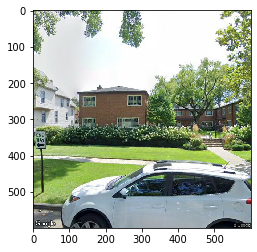

In [15]:
new_image = plt.imread('test_imgs/brick_7664.jpg')
img = plt.imshow(new_image)

In [16]:
#Sort the predictions from least to greatest
list_index = [0, 1, 2]
x = predictions

for i in range(3):
  for j in range(3):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

#Show the sorted labels in order
print(list_index)

[0, 1, 2]


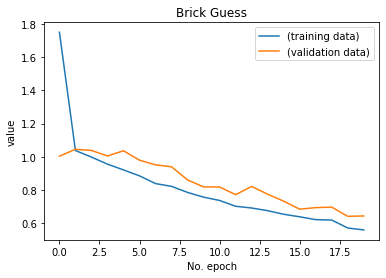

<Figure size 432x288 with 0 Axes>

In [22]:
# Plot history: 
plt.plot(history.history['loss'], label='(training data)')
plt.plot(history.history['val_loss'], label='(validation data)')
plt.title('Brick Guess')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()
plt.savefig('65pct.png')